- KEYWORDS: solve_ivp


So far we have focused on computational solutions to first order differential equations, including systems of first order differential equations. The reason for that is simply that all numerical integration strategies only work with the first derivative.

Many differential equations involve higher order derivatives though. We can solve these by converting them to systems of first-order differential equations through a series of variable changes.

Let's consider the [Van der Pol oscillator](https://en.wikipedia.org/wiki/Van_der_Pol_oscillator).

$\frac{d^2x}{dt^2} - \mu(1-x^2)\frac{dx}{dt} + x = 0$

We define a new variable: $v = x'$, and then have $v' = x''$.

That leads to a set of equivalent first-order differential equations:

$x' = v$

$v' - \mu (1-x^2)v + x = 0$

You can still think of $x$ as the position of the oscillator, and $y$ as the velocity of the oscillator. Now, we can integrate these equations from some initial condition.

Let's do this and plot the position and velocity of the oscillator. Rather than use `t_eval`, we will instead set the optional argument `max_step` to tell the solver how often it should make a step.

This is different than using `t_eval`, which uses interpolation *after* the solution has been found to evaluate the solution. This will become important later when we use events, which are only evaluated at the *solver* points.



In [26]:
import numpy as np
from scipy.integrate import solve_ivp

mu = 0.2

def dXdt(t, X):
    x, v = X
    dxdt = v
    dvdt = mu * (1 - x**2) * v - x
    return np.array([dxdt, dvdt])

X0 = np.array((1, 2)) # you can pick any x0, and v0 you want.
tspan = np.array((0, 40))
teval, h = np.linspace(*tspan, 501, retstep=True)
print(h)
sol = solve_ivp(dXdt, tspan, X0, max_step=h)
sol.message, sol.success
len(sol.t)


0.08


502

Now, we can plot the solutions.



(-2.0376594258233243, 2.0720662496386715)

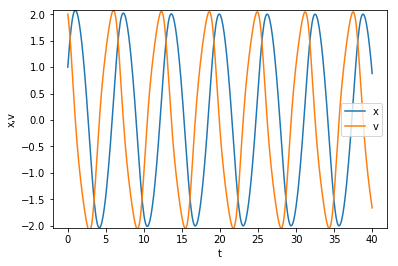

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(sol.t, sol.y.T);
plt.xlabel('t')
plt.ylabel('x,v')
plt.legend(['x', 'v'])
x, v = sol.y
plt.ylim([x.min(), x.max()])

You can see that the solution appears oscillatory. Let's be more quantitative than what it *looks* like. An alternative way to visualize this solution is called the phase portrait where we plot the two state variables (x, v) against each other. We include the starting point for visualization.



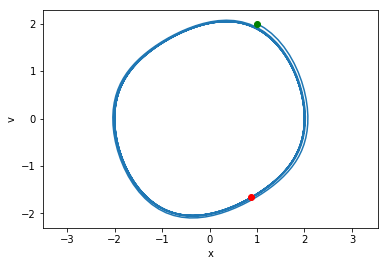

In [28]:
plt.plot(sol.y[0], sol.y[1])
plt.plot(*sol.y[:, 0], 'go') # starting point
plt.plot(*sol.y[:, -1], 'ro') # stopping point
plt.xlabel('x')
plt.ylabel('v')
plt.axis('equal');

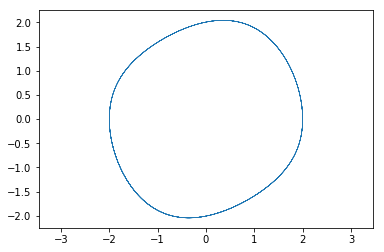

In [29]:
sol2 = solve_ivp(dXdt, tspan, sol.y[:, -1], max_step=h)
sol2.message, sol2.success
plt.plot(*sol2.y, lw=0.5)
plt.axis('equal');

So, evidently it is not exactly periodic in the beginning, but seems to take some time to settle down into a periodic rhythm. That seems to be the case, because if it didn't we would expect to see a continued spiral in or out of this limit cycle. Another way we can assess this quantitatively is to look at the peak positions in our solution. We return to an event type of solution. We seek an event where the derivative $dx/dt=0$, and it is a maximum, which means $x'$ starts positive, becomes zero, and then is negative. Note this is appropriate for this problem, where there is only one, periodic maximum. For other problems, you might need a different approach.

Now, it is important to remember that the event function is only evaluated after a solver point, so we need to make sure the solver points bracket where events occur. This is accomplished by making sure that when we graph the solution from the solver (not from t\_eval), that we can visually see where the events will occur.

We use a new optional argument, `dense_output=True` in `solve_ivp` which will let us evaluate the solution at the event times.



In [30]:
?solve_ivp

In [31]:
def max_x_event(t, X):
    x, v = X
    dxdt, dvdt = dXdt(t, X)
    return dxdt

# direction can be negative, 0 or positive
max_x_event.direction = -1 # event must go from positive to negative, i.e. a max

def min_x_event(t, X):
    x, v = X
    dxdt, dvdt = dXdt(t, X)
    return dxdt

# direction can be negative, 0 or positive
min_x_event.direction = 1 

sol = solve_ivp(dXdt, tspan, X0, max_step=h, events=[max_x_event, min_x_event],
                dense_output=True)
sol.success, sol.t_events

(True, [array([ 0.98712369,  7.29961546, 13.60207133, 19.90194031, 26.2010961 ,
         32.50005162, 38.79895061]),
  array([ 4.1456263 , 10.45140299, 16.75215845, 23.05156094, 29.35058591,
         35.64950451])])

1st array is for the time at max of x and 2nd in for min of x

You can see we found seven events. We need to evaluate the solution at these points, and we should plot them on the solution to see that they are in fact maxima. (what could possibly go wrong? if you get the wrong direction, then you will either see minima, or minima and maxima! If your event function is wrong, then it will just be wrong.) When you use `dense_output=True`, you get a new attribute on the solution which can be used to estimate the solution at some t values. Note we get two rows in our solution, one for x and one for v. From the numbers here, you can see that the x\_max values seem to be settling down to about 2.0.



In [32]:
sol.t_events[0]

array([ 0.98712369,  7.29961546, 13.60207133, 19.90194031, 26.2010961 ,
       32.50005162, 38.79895061])

In [33]:
sol.sol(sol.t_events[0])

array([[ 2.07283325e+00,  2.02004874e+00,  2.00590348e+00,
         2.00196135e+00,  2.00085099e+00,  2.00053732e+00,
         2.00044864e+00],
       [-6.24500451e-17,  4.16333634e-16,  7.38992201e-16,
        -1.60982339e-15, -1.62370117e-15,  1.48492330e-15,
        -1.21291865e-14]])

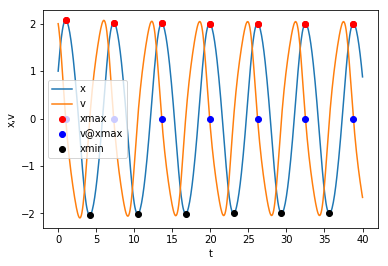

In [34]:
plt.plot(sol.t, sol.y.T)

# break up this calculation for ease of reading
te = sol.t_events[0]
xmax, v_at_xmax = sol.sol(te)
plt.plot(te, xmax, 'ro')
plt.plot(te, v_at_xmax, 'bo')

te2 = sol.t_events[1]
xmin, v_at_xmin = sol.sol(te2)
plt.plot(te2, xmin, 'ko')

# compare to. Don't do this, it is confusing and hard to figure out.
plt.plot(sol.t_events[0], sol.sol(sol.t_events[0])[0], 'ro')

plt.xlabel('t')
plt.ylabel('x,v')
plt.legend(['x', 'v', 'xmax', 'v@xmax', 'xmin'])

That looks good, the red dots appear at the maxima, and they are periodic, so now we can see how x<sub>max</sub> varies with time.



2.00044863772813

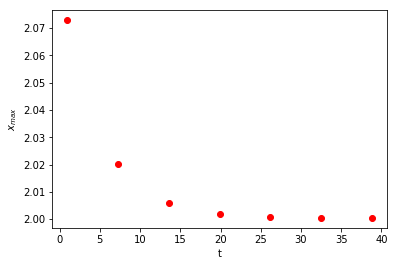

In [35]:
plt.plot(te, xmax, 'ro')
plt.xlabel('t')
plt.ylabel('$x_{max}$')
xmax[-1]

You can see that after about 5 cycles, xmax is practically constant. We can also see that the period (the time between maxima) is converging to a constant. We cannot say much about what happens at longer times. You could integrate longer if it is important to know that. This is a limitation of numerical methods though. To *prove* that it will be constant, you need to do some analytical math that would show the period and x<sub>max</sub> go to a constant.



In [37]:
?np.diff

In [43]:
# 3 methods of finding difference
np.diff(te)        #1
te[1:] - te[0:-1]  #2

dt = np.zeros(len(te) - 1)  #3
for i in range(len(te) - 1):
    dt[i] = te[i + 1] - te[i]
    
dt


array([6.31249177, 6.30245587, 6.29986898, 6.29915579, 6.29895552,
       6.29889899])

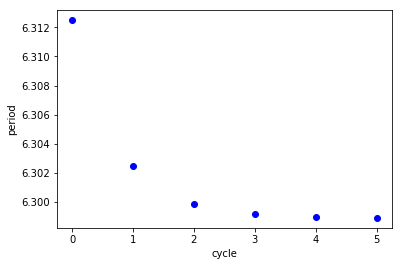

In [1]:
plt.plot(np.diff(te), 'bo')
plt.xlabel('cycle')
plt.ylabel('period')

If we seek the steady state, oscillatory behavior of this system, we should discard the solutions in at least the first 4 cycles, since the maxima and periods are still changing.



In [45]:
te[-1]
sol.sol(te[-1])

array([ 2.00044864e+00, -1.21291865e-14])

Alternatively, we can use the last point as an initial value for a new integration that should be close to steady state oscillations.



Text(0,0.5,'x,v')

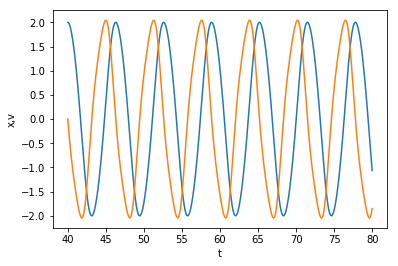

In [46]:
tspan = (40, 80)
X0 = sol.sol(te[-1])

sol2 = solve_ivp(dXdt, tspan, X0, max_step=h, events=max_x_event)
plt.plot(sol2.t, sol2.y.T)
plt.xlabel('t')
plt.ylabel('x,v')

Here you see about 6 more cycles. The period of these events is practically constant.



In [49]:
sol2.t_events, np.diff(sol2.t_events[0])

([array([46.29888301, 52.5977615 , 58.89663872, 65.19551558, 71.49439232,
         77.79326904])],
 array([6.29887849, 6.29887722, 6.29887686, 6.29887675, 6.29887672]))

And the limit cycle shows practically a single curve.



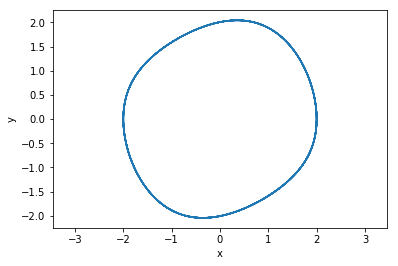

In [1]:
plt.plot(*sol2.y)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal'); # makes x-ticks have the same dimension as y-ticks

This limit cycle shows the oscillatory behavior. You can see here that each cycle repeats on top of itself.

**Review** We have been working on finding a steady state oscillatory solution to $\frac{d^2x}{dt^2} - \mu(1-x^2)\frac{dx}{dt} + x = 0$, which describes an oscillating system. We examined some ways to tell if a system is oscillating, and to estimate the period of the oscillation.




## Solving a parameterized ODE many times



$\mu$ in the Van der Pol system is called a parameter. It is common to study the solution of this system as a function of &mu;. For [example](https://en.wikipedia.org/wiki/Van_der_Pol_oscillator#/media/File:VanderPol-lc.svg), the oscillatory behavior changes a lot as &mu; changes. Our aim here is to recreate the figure in that example, showing the steady state limit cycles as a function of &mu;.

The example we want to create has limit cycles for 10 different values of &mu;. *We do not want to copy and paste code 10 times*. Instead, we should have some code we can *reuse 10 times*.

Let's break this task down. For a given &mu;, we should find a solution to the ODEs that shows constant periods. That means we should integrate over a time span, check the periods, and if they are not constant, integrate from the last point over the time span again. If they are consistent, then we can just plot the solution.

How can we check the periods are constant? One way is to see if the first and last are the same within some tolerance, say 1e-3.

Ideally, we would have a function that takes one argument, &mu;, and returns the steady state oscillatory solution.



In [58]:
# We do not have to define this here, I just repeat it so you can see it again.
def max_x_event(t, X):
    x, v = X
    Xprime = dXdt(t, X)
    return Xprime[0]  # first derivative = 0

max_x_event.direction = -1 # event must go from positive to negative, i.e. a max


def get_steady_state(mu):

    # define the sys odes for this mu. We define it inside the function so it
    # uses the mu passed in to get_steady_state.
    def dXdt(t, X):
        x, v = X
        dxdt = v
        dvdt = mu * (1 - x**2) * v - x
        return np.array([dxdt, dvdt])


    X0 = np.array([2, 0])  # start at x_max, velocity=0
    tspan = np.array([0, 40]) # we assume we will get 4-6 periods this way
    teval, h = np.linspace(*tspan, 1500, retstep=True)

    # initial solution
    sol = solve_ivp(dXdt, tspan, X0, max_step=h, events=max_x_event, dense_output=True)
    periods = np.diff(sol.t_events[0])

    # Now iterate as long as the first and last periods differ by more than the
    # tolerance. It is usually a good idea to provide a way to break out in case
    # it never ends. Here we use a max iteration count.
    i = 0

    # This assumes there are at least 2 periods in the tspan.
    while np.abs(periods[0] - periods[-1]) > 1e-3:
        last_step = sol.y[:, -1] # this is the new initial condition to continue from.
        sol = solve_ivp(dXdt, tspan, last_step, max_step=h, events=max_x_event, dense_output=True)
        # now get new periods.
        periods = np.diff(sol.t_events[0])
        i += 1
        if i > 5: # if we exceed 5 iterations, something is probably wrong, so stop.
            dp = np.abs(periods[0] - periods[-1])
            print(dp, periods)
            print(f'Max iterations exceeded and no stability for mu={mu}')
            break  # This breaks out of the while loop
    print(f'For mu={mu}, steady period after {i} iterations')

    # Finally, return the last solution
    return sol

For mu=4.0, steady period after 1 iterations
For mu=3.5, steady period after 1 iterations
For mu=3.0, steady period after 1 iterations
For mu=2.5, steady period after 1 iterations
For mu=2.0, steady period after 1 iterations
For mu=1.5, steady period after 1 iterations
For mu=1, steady period after 1 iterations
For mu=0.5, steady period after 1 iterations
For mu=0.1, steady period after 0 iterations
For mu=0.01, steady period after 0 iterations


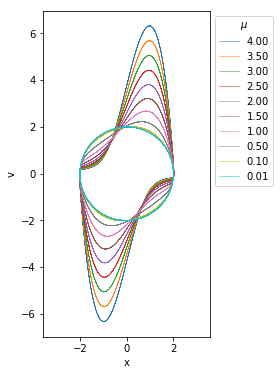

In [63]:
MU = [0.01, 0.1, 0.5, 1, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
MU.reverse()

plt.figure(figsize=(3, 6)) # 3 inches wide, 6 inches high  
for mu in MU:
    sol = get_steady_state(mu)
    plt.plot(*sol.y, lw=0.5, label=f'{mu:1.2f}')

plt.legend(title='$\mu$',
           loc='upper center',
           # this line says put the legend outside the box.
           # (0, 0) is the lower left, (1, 1) is the upper right
           bbox_to_anchor=(1.2, 1))

plt.axis('equal');
plt.xlabel('x')
plt.ylabel('v')

For mu=4, steady period after 1 iterations


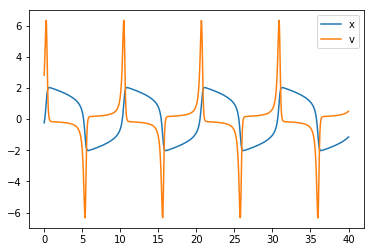

In [70]:
s4 = get_steady_state(4)
plt.plot(s4.t, s4.y.T)
plt.legend(['x', 'v'])

For mu=0.1, steady period after 0 iterations


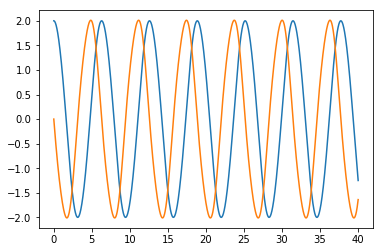

In [74]:
# This is an example of defining the ode outside our function, and using a for loop instead of a while loop.


def dX2dt(t, X, mu):
        x, v = X
        dxdt = v
        dvdt = mu * (1 - x**2) * v - x
        return np.array([dxdt, dvdt])

def get_steady_state_2(mu):

    # solve_ivp only takes functions of (t, X) so we have to define an internal function that defines mu here.
    def ode(t, X):
        return dX2dt(t, X, mu)
    

    X0 = np.array([2, 0])  # start at x_max, velocity=0
    tspan = np.array([0, 40]) # we assume we will get 4-6 periods this way
    teval, h = np.linspace(*tspan, 1500, retstep=True)

    # initial solution
    sol = solve_ivp(ode, tspan, X0, max_step=h, events=max_x_event, dense_output=True)
    periods = np.diff(sol.t_events[0])

    # Now iterate as long as the first and last periods differ by more than the
    # tolerance. 
    
    for i in range(5):
        # break out if the difference is less than tolerance
        d = np.diff(periods)
        if np.sum(np.abs(d)) < 1e-3:
            break  # if periods are constant, break out of loop
            
        last_step = sol.y[:, -1] # get last step
        # restart integration
        sol = solve_ivp(dXdt, tspan, last_step, max_step=h, events=max_x_event, dense_output=True)
        # check periods
        periods = np.diff(sol.t_events[0])
        

            
    if i == 4:
        dp = np.abs(periods[0] - periods[-1])
        print(dp, periods)
        print(f'Max iterations exceeded and no stability for mu={mu}')
        
    print(f'For mu={mu}, steady period after {i} iterations')

    # Finally, return the last solution
    return sol

s2 = get_steady_state_2(0.1)
plt.plot(s2.t, s2.y.T)


# Summary



Today we covered the conversion of an n<sup>th</sup> order differential equation into a system of first order differential equations.

We examined the use of the optional argument max\_step to fine tune the solution points returned by the solver.

This concludes our the first section on ordinary differential equations.

On Wed, I will answer questions for about half of the class, and we will have a quiz on the second half of class. The quiz will be a single question, and will be representative of the exam next week.

